In [1]:
import os.path

import matplotlib.pyplot as plt
# Imports for ML model

import numpy as np
import tensorflow as tf
import keras
from keras.layers import Normalization



In [47]:
# Filter out corrupted images
num_skipped = 0
data_label = []
for folder_name in ("Apple_Black_rot", "Apple_Cedar_apple_rust", "Apple_healthy", "Apple_Powdery_mildew", "Apple_scab"):
    folder_path = os.path.join("testPlants", folder_name)
    for f_name in os.listdir(folder_path):
        f_path = os.path.join(folder_path, f_name)
        try:
            f_obj = open(f_path, "rb")
            is_jpg = tf.compat.as_bytes("JFIF") in f_obj.peek(10)
        finally:
            f_obj.close()
        if not is_jpg:
            num_skipped += 1
            # Delete corrupted images
            os.remove(f_path)

Found 180 files belonging to 5 classes.


In [48]:
# Generate a Dataset
image_size = (200, 200)
batch_site = 64
train_labels = [(1, 'Apple_Black_rot'), (2, 'Apple_Cedar_apple_rust'), (3, 'Apple_healthy'), (4, 'Apple_Powdery_mildew'),(5, 'Apple_scab')]

(train_data, train_labels), (test_data, test_labels) = tf.keras.utils.image_dataset_from_directory(
    "testPlants",
    validation_split= 0.2,
    subset= "both",
    seed= 1337,
    image_size=image_size,
    batch_size=batch_site,
    labels= "inferred"
)


Found 180 files belonging to 5 classes.
Using 144 files for training.
Using 36 files for validation.


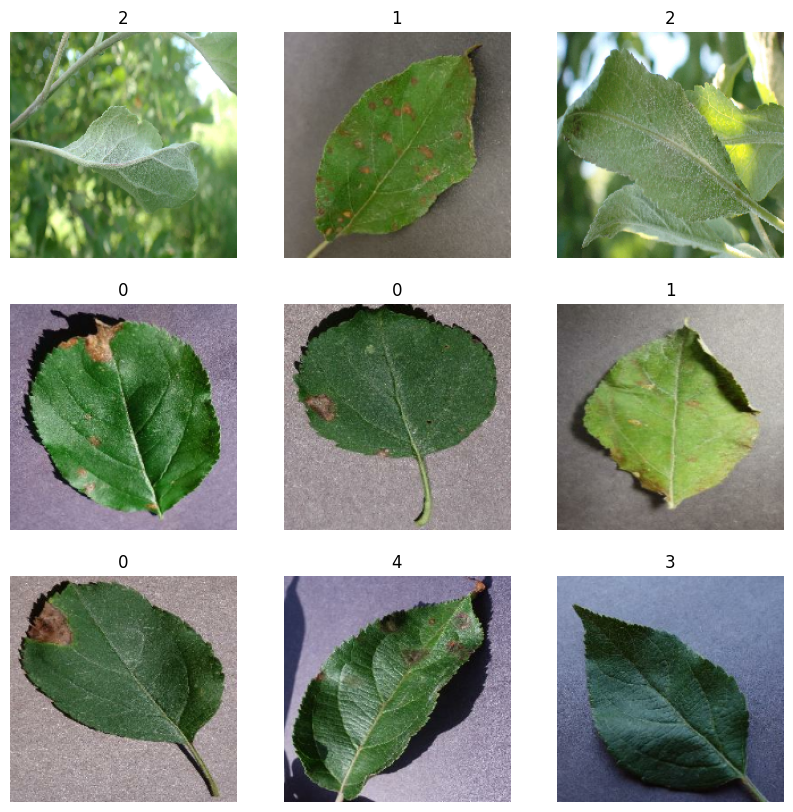

In [49]:
# Visualization of data
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
    for i in range (9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

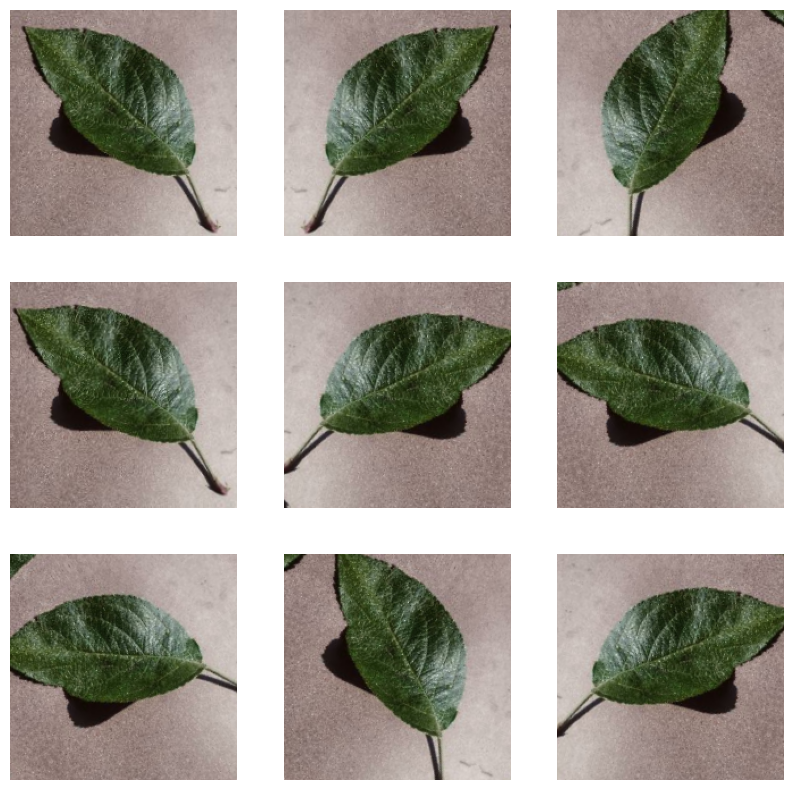

In [50]:
# Using image data augmentation
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [51]:
# Preprocessing data for ML model
# augmentation will happen on CPU
# Apply `data_augmentation` to the training images.
augmented_train_ds = train_data.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls = tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)


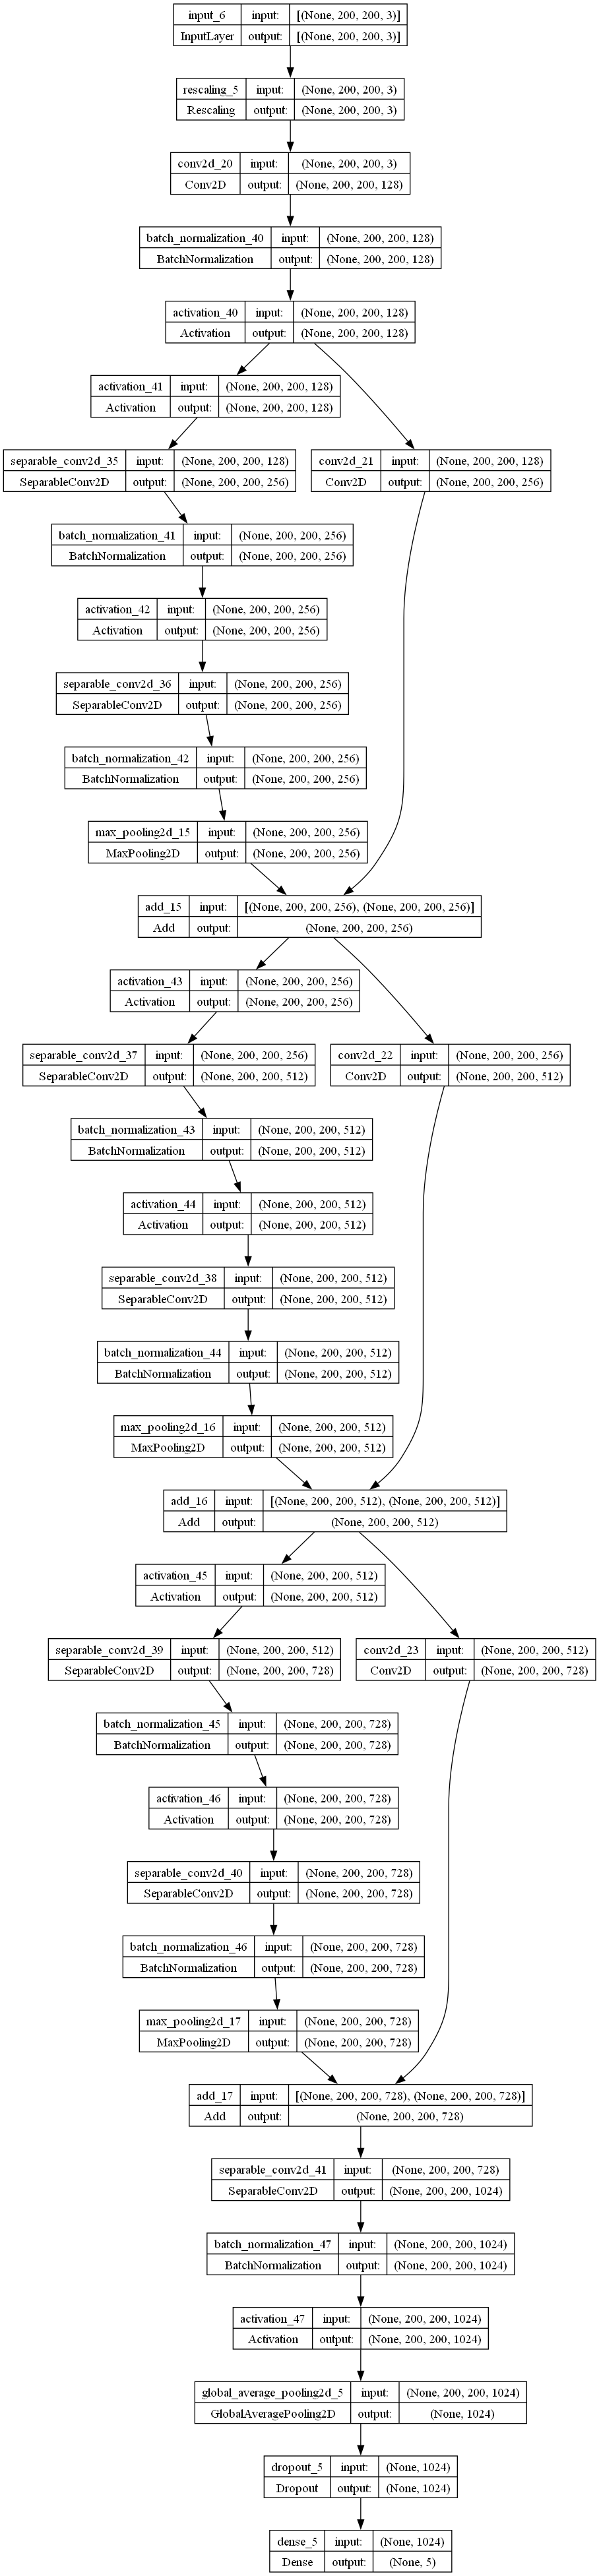

In [52]:
# Build a model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    #Entry block
    x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
    x = tf.keras.layers.Conv2D(128,3,strides=1, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    previous_block_activation = x #set aside residual
    
    for size in [256, 512, 728]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.MaxPooling2D(3, strides=1, padding="same")(x)
        
        #Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=1, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual]) # Add back residual
        previous_block_activation = x # Set aside next residual
        
    x = tf.keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    #if num_classes == 2:
    #    activation = "sigmoid"
    #    units = 1
    #else:
    activation = "softmax"
    units = 5    
        
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(image_size + (3,), 5)
keras.utils.plot_model(model, show_shapes=True)


In [53]:
# Train the model
from keras.callbacks import ModelCheckpoint
#epochs = 25

callbacks = [
    ModelCheckpoint("model_weights_epoch_{epoch}.h5", save_best_only=True),
]

# Instantiate the BinaryFocalCrossentropy loss function
loss_fn = keras.losses.BinaryCrossentropy()

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=loss_fn,  # Use the instantiated loss function
    metrics=["accuracy"],
)

model.fit(
    train_data,
    epochs=25,
    callbacks=callbacks,
    validation_data=test_data,
)

Epoch 1/25


ValueError: in user code:

    File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\losses.py", line 2432, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\backend.py", line 5809, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 5) vs (None, 1)).
